## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import preprocess_input as vgg16_preproc
from keras.applications.densenet import preprocess_input as dense_preproc
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2295592376078147290
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5594360618339105039
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8819821760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12500721456975067203
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12831007560451114404
physical_device_desc: "device: XLA_GPU device"
]


## Do some early processing of your metadata for easier model training:

The images and data are stored outside this project and can be downloaded [here](https://www.kaggle.com/nih-chest-xrays/data).

In [3]:
! ls ../p1_data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_008	       README_CHESTXRAY.pdf
BBox_List_2017.csv	images_003  images_009	       test_list.txt
-c			images_004  images_010	       train_val_list.txt
Data_Entry_2017.csv	images_005  images_011
FAQ_CHESTXRAY.pdf	images_006  images_012
images_001		images_007  LOG_CHESTXRAY.pdf


In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('../p1_data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../p1_data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89580,00022243_000.png,Effusion|Pleural_Thickening,0,22243,76,F,AP,3056,2544,0.139,0.139,NaN,../p1_data/images_010/images/00022243_000.png
93236,00023302_000.png,No Finding,0,23302,39,F,PA,2544,3056,0.139,0.139,NaN,../p1_data/images_010/images/00023302_000.png
541,00000129_000.png,No Finding,0,129,66,F,PA,2462,2991,0.143,0.143,NaN,../p1_data/images_001/images/00000129_000.png


In [5]:
## Create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

labels = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
unique_labels = np.unique(list(chain(*labels)))
print(unique_labels)

for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda findings: 1 if ul in findings else 0)
all_xray_df.sample(10)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
22791,00006024_004.png,No Finding,4,6024,61,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
9225,00002410_004.png,No Finding,4,2410,43,F,PA,2530,2553,0.143,...,0,0,0,0,0,1,0,0,0,0
72331,00017820_000.png,No Finding,0,17820,45,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
9272,00002417_004.png,No Finding,4,2417,60,M,AP,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
41045,00010627_001.png,Edema,1,10627,50,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
43664,00011242_003.png,No Finding,3,11242,40,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
5820,00001563_000.png,No Finding,0,1563,56,F,PA,2902,2733,0.143,...,0,0,0,0,0,1,0,0,0,0
49446,00012543_014.png,No Finding,14,12543,65,M,PA,2820,2902,0.143,...,0,0,0,0,0,1,0,0,0,0
103301,00027547_003.png,Pneumothorax,3,27547,35,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,1
51240,00012939_002.png,Effusion,2,12939,57,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


In [6]:
all_xray_df['Pneumonia Class'] = np.where(all_xray_df.Pneumonia==1, 'Pneumonia', 'No pneumonia')

In [7]:
# prevalence of pneumonia in the dataset
all_xray_df.Pneumonia.sum()/len(all_xray_df) * 100

1.2763110952550838

## Create your training and testing data:

In [8]:
def create_splits(column, test_size=0.2, valid_neg_delta=4):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = test_size, 
                                   stratify = all_xray_df[column])
    ## Split the train_df so that there are equal proportions of pneumonia and no pneumonia in train set
    positive_inds = train_df[train_df.Pneumonia==1].index.tolist()
    negative_inds = train_df[train_df.Pneumonia==0].index.tolist()

    # throw away some negative data 
    # pick positive number of negative cases
    negative_sample = sample(negative_inds, len(positive_inds)) 
    # select all existing positive cases + negative cases (of size positive_inds)
    train_df = train_df.loc[positive_inds + negative_sample] 
    
    ## Split validation set 10-90 (pos-neg)
    positive_inds_valid = valid_df[valid_df.Pneumonia==1].index.tolist()
    negative_inds_valid = valid_df[valid_df.Pneumonia==0].index.tolist()
    
    # negative sample 9x bigger than positive
    negative_sample_valid = sample(negative_inds_valid, valid_neg_delta * len(positive_inds_valid)) 
    valid_df = valid_df.loc[positive_inds_valid + negative_sample_valid]
    
    return train_df, valid_df

In [9]:
train, valid = create_splits('Pneumonia')
train.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
90165,00022416_036.png,Atelectasis|Effusion,36,22416,52,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,No pneumonia
19797,00005273_000.png,No Finding,0,5273,40,F,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,No pneumonia
38302,00010012_024.png,Edema|Infiltration|Pneumonia,24,10012,53,M,AP,2500,2048,0.168,...,0,0,1,0,0,0,0,1,0,Pneumonia
40497,00010531_058.png,Effusion|Infiltration|Pleural_Thickening|Pneum...,58,10531,24,F,PA,2992,2991,0.143,...,0,0,1,0,0,0,1,1,0,Pneumonia
75818,00018610_018.png,Infiltration,18,18610,64,M,AP,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,No pneumonia


In [10]:
train.Pneumonia.sum()/len(train), valid.Pneumonia.sum()/len(valid)

(0.5, 0.2)

In [11]:
len(train), len(valid)

(2290, 1430)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
target_size = (224, 224)
batch_size = 32

In [13]:
def my_image_augmentation(params):
    my_idg = ImageDataGenerator(**params)
    return my_idg


def make_train_gen(target_size, batch_size, preprocess_input):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    idg = my_image_augmentation({'rescale': 1.0/255.0,
                                'horizontal_flip':True,
                                'vertical_flip':False,
                                'height_shift_range':0.1, 
                                'width_shift_range':0.1, 
                                'rotation_range':10, 
                                'shear_range':0.1,
                                'zoom_range':0.1,
                                'preprocessing_function':preprocess_input}
                               )
    
    train_gen = idg.flow_from_dataframe(dataframe=train, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia',
                                                 class_mode = 'raw',
                                                 shuffle = True,
                                                 target_size = target_size, 
                                                 batch_size = batch_size
                                                )

    return train_gen


def make_val_gen(target_size, batch_size, preprocess_input):
    idg = my_image_augmentation({'rescale': 1.0/255.0,
                                 'preprocessing_function':preprocess_input})
    
    val_gen = idg.flow_from_dataframe(dataframe=valid, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia',
                                                 class_mode = 'raw',
                                                 target_size = target_size, 
                                                 batch_size = 128
                                                )
    
    return val_gen

In [14]:
train_gen = make_train_gen(target_size, batch_size, vgg16_preproc) 
val_gen = make_val_gen(target_size, batch_size, vgg16_preproc)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

shape (224, 224, 3)


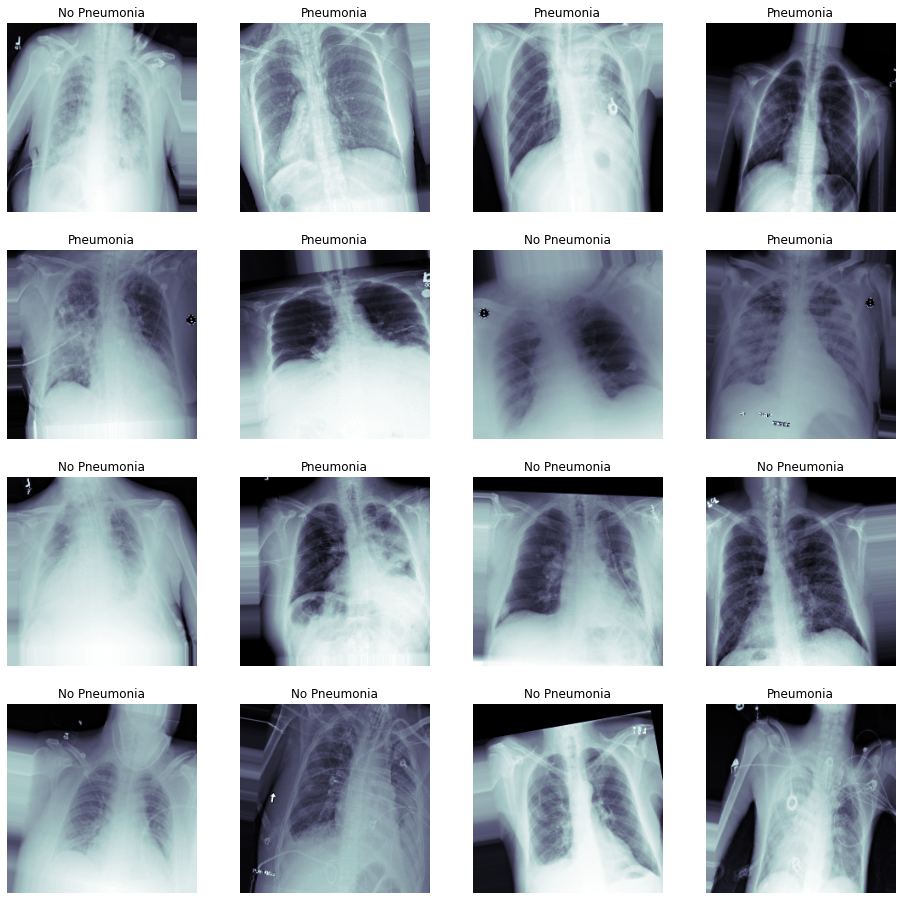

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
print("shape", t_x[0].shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

Lets plot the intensity histograms for the above images. We see they vary a lot, with no clear differentiating intensity. At most one can maybe say pneumonia is _sometimes_ more intense.

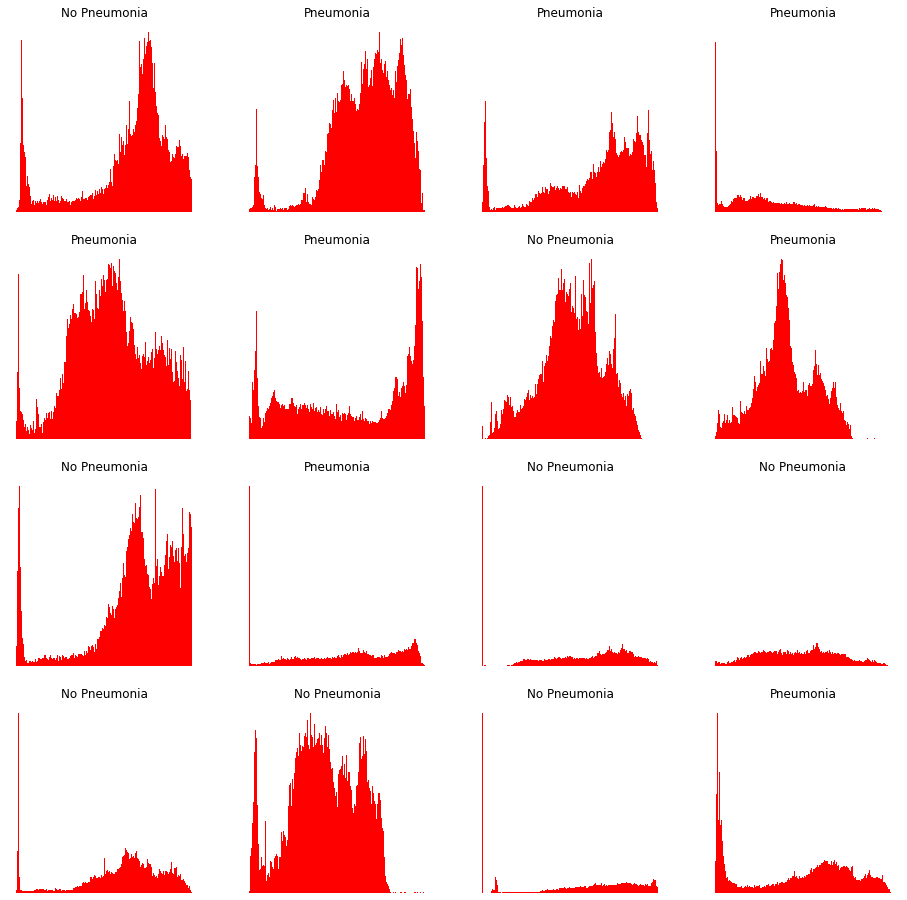

In [17]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].flatten(), bins=256, color = 'red')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_vgg16(unfrozen_end):   
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    for layer in model.layers[:-unfrozen_end]:
        layer.trainable = False
        
    return model

In [19]:
def compile(model, lr):
    ## Set the optimizer, loss function, and learning rate
    optimizer = Adam(lr=lr)
    loss = 'binary_crossentropy' # 2 classes, pos/neg for pneumonia 
    metrics = ['binary_accuracy', 'mae']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def build_model(pretrained_model, list_of_layers, model_type, lr=1e-4, dropout=0.25):    
    model = Sequential()
    if pretrained_model:
        model.add(pretrained_model)
    
    if model_type == 'vgg16':
        model.add(Flatten())
        model.add(Dropout(dropout))
    
        for i, layer_nodes in enumerate(list_of_layers):
            last_layer = i == (len(list_of_layers) - 1)
            activation = 'sigmoid' if last_layer else 'relu'
            model.add(Dense(layer_nodes, activation=activation))
            if not last_layer:
                model.add(Dropout(dropout))

    model = compile(model, lr)
    
    return model

In [20]:
def make_callbacks(path):
    checkpoint = ModelCheckpoint(path, 
                                  monitor='val_loss', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode='min', 
                                  save_weights_only = True)

    early = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           patience=10)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                                  patience=3, min_lr=1e-5)
    
    return [checkpoint, early, reduce_lr]

### Start training! 

In [21]:
def train_model(pretrained, layers, lr, dropout, model_type, callbacks_list):
    try:
        history = None
        
        model = build_model(pretrained, list_of_layers=layers, lr=lr, dropout=dropout, model_type=model_type)
        model.summary()

        history = model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 30, 
                              callbacks = callbacks_list,
                              steps_per_epoch = len(train_gen))
        return history, model
    except KeyboardInterrupt:
        print('\n\nTraining interrupted.')

In [32]:
path1 = "{}_my_model_vgg.best1.hdf5".format('xray_class')
path2 = "{}_my_model_vgg.best2.hdf5".format('xray_class')

In [28]:
pretrained_vgg16 = load_pretrained_vgg16(unfrozen_end=2)    
model_vgg_history, model_vgg = None, None

try:
    model_vgg_history, model_vgg = train_model(pretrained_vgg16, 
                                       layers=[512, 256, 1], 
                                       lr=0.00001, 
                                       dropout=0.2, 
                                       model_type='vgg16', 
                                       callbacks_list=make_callbacks(path1))
except TypeError:
    pass

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)              

In [29]:
pretrained_vgg16 = load_pretrained_vgg16(unfrozen_end=1)  
model2_vgg_history, model2_vgg = None, None
try:
    model2_vgg_history, model2_vgg = train_model(pretrained_vgg16,
                                       layers=[512, 256, 1],
                                       lr=0.0001, 
                                       dropout=0.4, 
                                       model_type='vgg16',
                                       callbacks_list=make_callbacks(path2))
except KeyError:
    pass

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)              

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [33]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model2_vgg.load_weights(path2)
pred_Y2 = model2_vgg.predict(valX, batch_size = 32, verbose = True)

model_vgg.load_weights(path1)
pred_Y = model_vgg.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 0s 2ms/step


In [34]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

def plot_precision_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return precision, recall, thresholds

def f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)
    
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

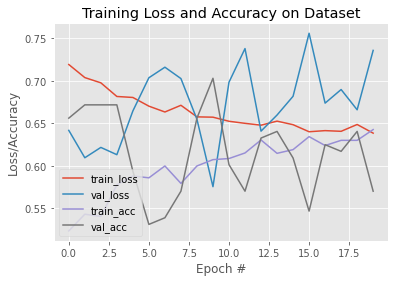

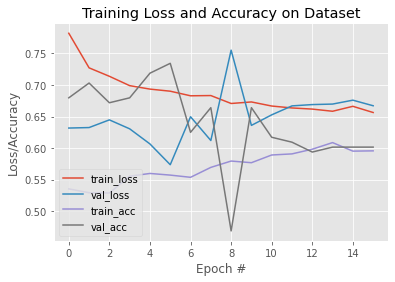

In [36]:
## plot figures
plot_history(model_vgg_history)
plot_history(model2_vgg_history)


No handles with labels found to put in legend.


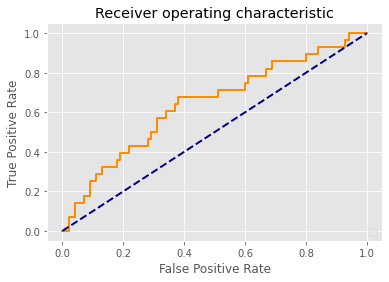

No handles with labels found to put in legend.


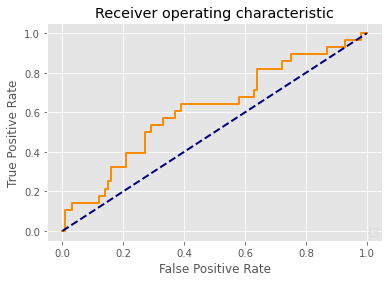

In [37]:
plot_auc(valY, pred_Y);
plot_auc(valY, pred_Y2);

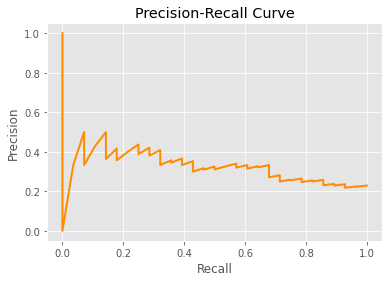

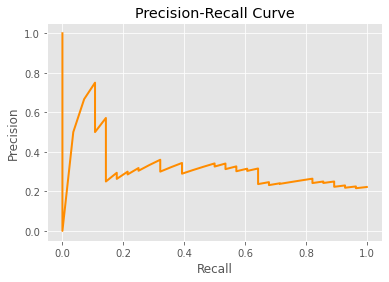

In [38]:
precision, recall, thresholds = plot_precision_recall(valY, pred_Y)
precision2, recall2, thresholds2 = plot_precision_recall(valY, pred_Y2)

[Text(0, 0.5, 'precision/recall'),
 Text(0.5, 0, 'threshold'),
 Text(0.5, 1.0, 'VGG 16 v2')]

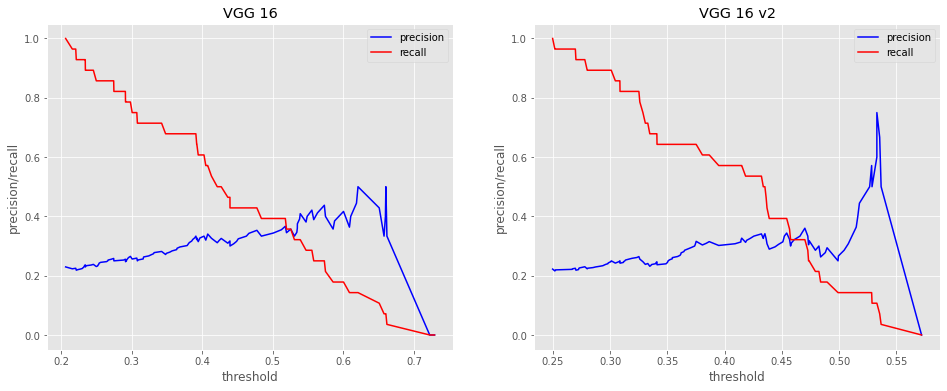

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(thresholds, precision[:-1], color='blue', label="precision")
ax1.plot(thresholds, recall[:-1], color='red', label="recall")

ax2.plot(thresholds2, precision2[:-1], color='blue', label="precision")
ax2.plot(thresholds2, recall2[:-1], color='red', label="recall")

ax1.legend()
ax2.legend()

ax1.set(xlabel='threshold', ylabel="precision/recall", title="VGG 16")
ax2.set(xlabel='threshold', ylabel="precision/recall", title="VGG 16 v2")

<ipython-input-34-109d68f0002b>:22: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall) / (precision + recall)


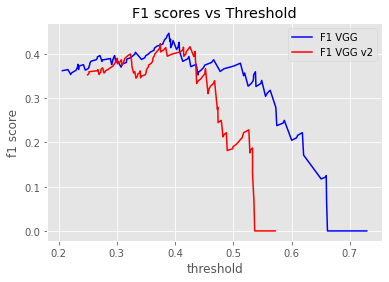

In [42]:
import math
# F1 scores by threshold using above thresholds, precision, and recall values
def calc_f1_scores(thresholds, precision, recall):
    def find_threshold_and_calc(cur_th):
        for i, th in enumerate(thresholds):
            if th > cur_th:
                f1_score = f1(precision[i], recall[i])
                if not math.isnan(f1_score):
                    return f1_score
                else:
                    return 0
        return 0
    return [find_threshold_and_calc(cur_th) for cur_th in thresholds]
    

f1_scores = calc_f1_scores(thresholds, precision, recall)
f1_scores2 = calc_f1_scores(thresholds2, precision2, recall2)
plt.plot(thresholds, f1_scores, color='blue', label='F1 VGG')
plt.plot(thresholds2, f1_scores2, color='red', label='F1 VGG v2')
plt.xlabel('threshold')
plt.ylabel('f1 score')
plt.title('F1 scores vs Threshold')
plt.legend()

In [43]:
# maximum F1 scores
f1_vgg = f1_scores[np.argmax(f1_scores)]
f1_vgg2 = f1_scores2[np.argmax(f1_scores2)]
f1_vgg, f1_vgg2

(0.4470588235294118, 0.4235294117647059)

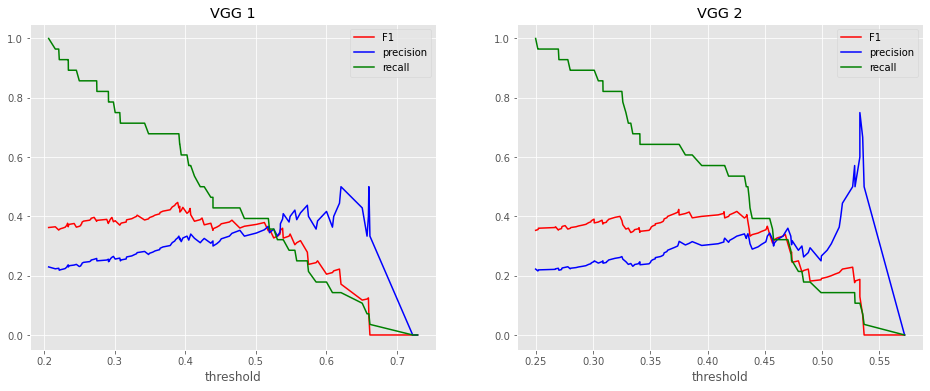

In [45]:
# f1, recall, precision vs thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(thresholds, f1_scores, color='red', label='F1')
ax1.plot(thresholds, precision[:-1], color='blue', label='precision')
ax1.plot(thresholds, recall[:-1], color='green', label='recall')

ax1.set(xlabel='threshold', title='VGG 1')
ax1.legend()

ax2.plot(thresholds2, f1_scores2, color='red', label='F1')
ax2.plot(thresholds2, precision2[:-1], color='blue', label='precision')
ax2.plot(thresholds2, recall2[:-1], color='green', label='recall')
ax2.set(xlabel='threshold', title='VGG 2')
ax2.legend()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide).

In [63]:
vgg_threshold = [0.3, 0.33, 0.35, 0.37, 0.39, 0.4, 0.45, 0.5]
for t in vgg_threshold:
    tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > t).astype(int)).ravel()
    print(f'Threshold: {t}.. True neg: {tn}; True pos: {tp}; False neg: {fn}; False pos: {fp}')

Threshold: 0.3.. True neg: 39; True pos: 21; False neg: 7; False pos: 61
Threshold: 0.33.. True neg: 47; True pos: 20; False neg: 8; False pos: 53
Threshold: 0.35.. True neg: 51; True pos: 19; False neg: 9; False pos: 49
Threshold: 0.37.. True neg: 56; True pos: 19; False neg: 9; False pos: 44
Threshold: 0.39.. True neg: 62; True pos: 19; False neg: 9; False pos: 38
Threshold: 0.4.. True neg: 66; True pos: 17; False neg: 11; False pos: 34
Threshold: 0.45.. True neg: 75; True pos: 12; False neg: 16; False pos: 25
Threshold: 0.5.. True neg: 79; True pos: 11; False neg: 17; False pos: 21


In [54]:
vgg2_thresholds = [0.3, 0.33, 0.35, 0.37, 0.4, 0.45, 0.5]
for t in vgg2_thresholds:
    tn, fp, fn, tp = confusion_matrix(valY, (pred_Y2 > t).astype(int)).ravel()
    print(f'Threshold: {t}.. True neg: {tn}; True pos: {tp}; False neg: {fn}; False pos: {fp}')

Threshold: 0.3.. True neg: 24; True pos: 25; False neg: 3; False pos: 76
Threshold: 0.33.. True neg: 36; True pos: 20; False neg: 8; False pos: 64
Threshold: 0.35.. True neg: 45; True pos: 18; False neg: 10; False pos: 55
Threshold: 0.37.. True neg: 57; True pos: 18; False neg: 10; False pos: 43
Threshold: 0.4.. True neg: 64; True pos: 16; False neg: 12; False pos: 36
Threshold: 0.45.. True neg: 76; True pos: 11; False neg: 17; False pos: 24
Threshold: 0.5.. True neg: 90; True pos: 4; False neg: 24; False pos: 10


In [55]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification.

YOUR_THRESHOLD = 0.39
testY = valY

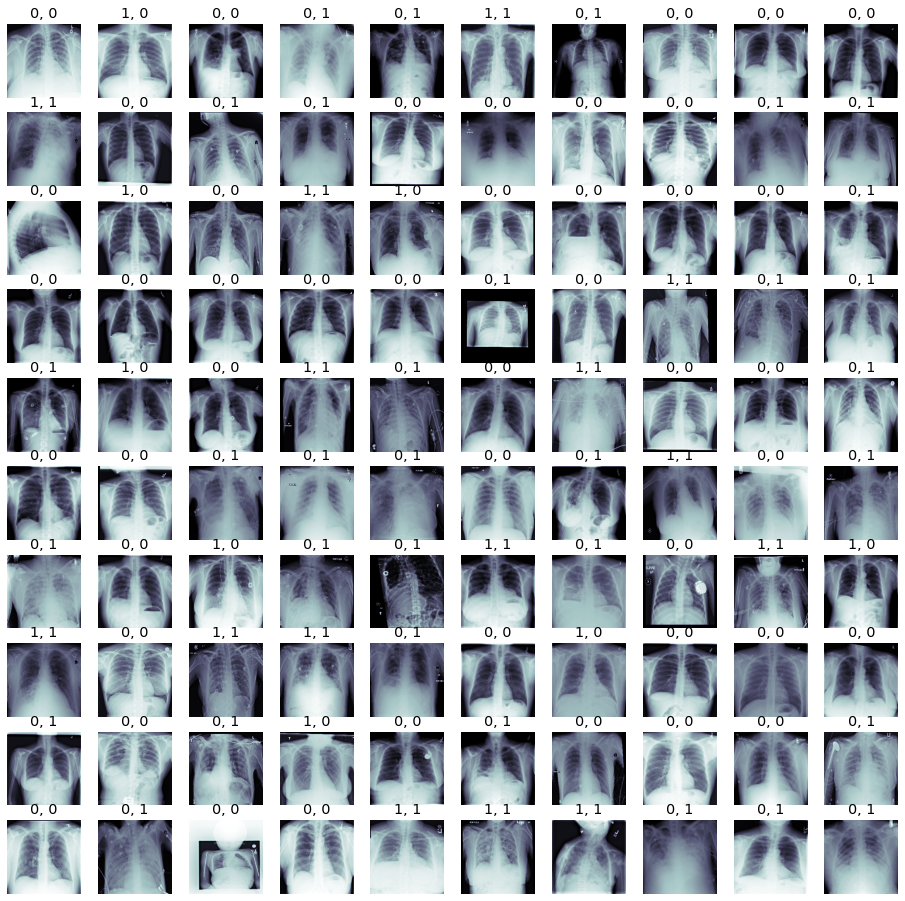

In [56]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [60]:
## Just save model architecture to a .json:

model_json = model_vgg.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [61]:
## Just save model architecture to a .json:

model2_json = model2_vgg.to_json()
with open("model2_vgg.json", "w") as json_file:
    json_file.write(model2_json)